In [1]:
from timeseries_ml_utils.data import DataFetcher, DataGenerator
from timeseries_ml_utils.statistics import RelativeAccuracy
from scipy.fftpack import dct, idct
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, GRU, Embedding, LSTM
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.utils import plot_model
from keras.callbacks import TensorBoard
import keras
import matplotlib.pyplot as plt
import re

Using TensorFlow backend.


In [2]:
# fetch data
data = DataFetcher(["GLD.US"], limit=1000)
data.fetch_data().tail()


,GLD.US.Open,GLD.US.High,GLD.US.Low,GLD.US.Close,GLD.US.Volume
Date,,,,,
2018-11-12,114.01,114.05,113.58,113.66,7499046
2018-11-13,113.72,113.93,113.42,113.70,9309074
2018-11-14,113.53,115.06,113.46,114.64,13950218
2018-11-15,114.83,114.99,114.56,114.77,8910585
2018-11-16,115.83,115.88,115.37,115.62,8576955


In [3]:
print(len(data.get_dataframe()))
model_data = DataGenerator(data.get_dataframe(), {"^trigonometric": False, "(Open|High|Low|Close)$": True}, {"GLD.US.Close$": True}, aggregation_window_size=16)
print(model_data.batch_feature_shape)
print(model_data.batch_label_shape)
acc_callback = RelativeAccuracy(model_data)
model_data.features, model_data.labels


1000


(100, 260, 224)
(100, 16)


([('GLD.US.Open', True),
  ('GLD.US.High', True),
  ('GLD.US.Low', True),
  ('GLD.US.Close', True),
  ('trigonometric_time.cos_dow', False),
  ('trigonometric_time.sin_dow', False),
  ('trigonometric_time.cos_woy', False),
  ('trigonometric_time.sin_woy', False),
  ('trigonometric_time.cos_doy', False),
  ('trigonometric_time.sin_doy', False),
  ('trigonometric_time.sin_yer', False),
  ('trigonometric_time.cos_yer', False),
  ('trigonometric_time.sin_dec', False),
  ('trigonometric_time.cos_dec', False)],
 [('GLD.US.Close', True)])

In [4]:
model = Sequential()
model.add(LSTM(model_data.batch_label_shape[-1],
               name="LSTM-Layer-1",
               batch_input_shape=model_data.batch_feature_shape,
               activation='tanh',
               dropout=0,
               recurrent_dropout=0,
               stateful=True,
               return_sequences=model_data.return_sequences))

model.compile("Adam", loss="mse")
print(model.layers[0].get_weights()[0][0])
model.save("/tmp/keras-foo-1.h5")

[-8.46408904e-02  9.06054825e-02 -8.77263099e-02 -9.01478678e-02
  2.53351182e-02  6.19910359e-02  1.17081285e-01 -6.61904588e-02
  1.04809076e-01 -1.27218321e-01  1.39265567e-01 -3.55124548e-02
  3.64791453e-02  1.34711057e-01  4.82980311e-02 -6.92014396e-02
 -9.70360637e-03  2.52812356e-02 -1.25974819e-01  1.03378192e-01
 -1.02290750e-01 -2.36506835e-02  1.39044374e-01  1.25860661e-01
 -1.15561992e-01  1.18726969e-01 -7.11169913e-02 -8.94464999e-02
 -7.31655806e-02 -6.75761923e-02  9.69909430e-02  1.00638494e-01
  3.74285579e-02  6.66471124e-02  5.03189862e-03 -1.38952181e-01
  1.09759271e-01 -6.35210946e-02  9.95662212e-02  3.21266204e-02
  9.87560451e-02 -1.09963901e-01  9.47879106e-02 -1.36463344e-03
 -7.61419535e-04 -5.51483035e-02  4.65828627e-02 -7.24725425e-03
 -1.42437875e-01 -1.62983239e-02  1.39020860e-01  1.03431940e-01
 -7.70024359e-02  2.99070776e-03  2.82519460e-02 -1.18371695e-02
 -9.01396722e-02  1.38023406e-01 -1.36952400e-02  1.34843290e-02
 -7.55823180e-02 -5.59375

In [4]:
model = load_model("/tmp/keras-foo-1.h5")
hist = model.fit_generator(generator=model_data,
                           validation_data=model_data.as_test_data_generator(model),
                           epochs=1,
                           use_multiprocessing=True,
                           workers=4,
                           shuffle=False,
                           callbacks=[acc_callback, TensorBoard(log_dir='./.logs')])


Epoch 1/1


  1/500 [..............................] - ETA: 30:05 - loss: 0.9610

/home/kic/sources/github/python/timeseries_ml_utils/timeseries_ml_utils/statistics.py:9: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  prediction_distance = fastdtw(x, y)[0]



 [0.08361976 0.10106866 0.11851756 0.13596646 0.15341536 0.17086425
 0.18831315 0.20576205 0.22321095 0.24065985 0.25810875] 



/home/kic/sources/github/python/timeseries_ml_utils/venv/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (4.678420). Check your callbacks.
  % delta_t_median)


  2/500 [..............................] - ETA: 35:26 - loss: 0.9019

/home/kic/sources/github/python/timeseries_ml_utils/venv/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.339586). Check your callbacks.
  % delta_t_median)


  3/500 [..............................] - ETA: 24:16 - loss: 0.8489

  4/500 [..............................] - ETA: 18:49 - loss: 0.8007

  5/500 [..............................] - ETA: 15:39 - loss: 0.7569

  6/500 [..............................] - ETA: 13:36 - loss: 0.7172


 [0.18546361 0.21474733 0.24403105 0.27331477 0.30259849 0.33188222
 0.36116594 0.39044966 0.41973338 0.4490171  0.47830082] 



  7/500 [..............................] - ETA: 15:19 - loss: 0.6813

  8/500 [..............................] - ETA: 13:37 - loss: 0.6490

  9/500 [..............................] - ETA: 12:23 - loss: 0.6199

 10/500 [..............................] - ETA: 11:24 - loss: 0.5935

 11/500 [..............................] - ETA: 10:37 - loss: 0.5695


 [0.35558074 0.38198752 0.40839429 0.43480107 0.46120785 0.48761463
 0.5140214  0.54042818 0.56683496 0.59324174 0.61964851] 



 12/500 [..............................] - ETA: 11:50 - loss: 0.5478

 13/500 [..............................] - ETA: 11:04 - loss: 0.5282

 14/500 [..............................] - ETA: 10:27 - loss: 0.5103

 15/500 [..............................] - ETA: 9:55 - loss: 0.4940 

 16/500 [..............................] - ETA: 9:28 - loss: 0.4792


 [0.4510554  0.47820355 0.5053517  0.53249986 0.55964801 0.58679616
 0.61394431 0.64109246 0.66824061 0.69538876 0.72253691] 



 17/500 [>.............................] - ETA: 10:25 - loss: 0.4656

 18/500 [>.............................] - ETA: 9:55 - loss: 0.4531 

 19/500 [>.............................] - ETA: 9:32 - loss: 0.4417

 20/500 [>.............................] - ETA: 9:13 - loss: 0.4311

 21/500 [>.............................] - ETA: 8:55 - loss: 0.4212


 [0.52747303 0.55239419 0.57731535 0.60223652 0.62715768 0.65207885
 0.67700001 0.70192117 0.72684234 0.7517635  0.77668467] 



 22/500 [>.............................] - ETA: 9:41 - loss: 0.4120

 23/500 [>.............................] - ETA: 9:20 - loss: 0.4033

 24/500 [>.............................] - ETA: 9:02 - loss: 0.3952

 25/500 [>.............................] - ETA: 8:46 - loss: 0.3874

 26/500 [>.............................] - ETA: 8:31 - loss: 0.3800


 [0.59001245 0.61265087 0.6352893  0.65792772 0.68056615 0.70320458
 0.725843   0.74848143 0.77111985 0.79375828 0.8163967 ] 



 27/500 [>.............................] - ETA: 9:06 - loss: 0.3730

 28/500 [>.............................] - ETA: 8:50 - loss: 0.3662

 29/500 [>.............................] - ETA: 8:36 - loss: 0.3597

 30/500 [>.............................] - ETA: 8:24 - loss: 0.3534

 31/500 [>.............................] - ETA: 8:12 - loss: 0.3473


 [0.64143437 0.66118908 0.68094379 0.7006985  0.72045321 0.74020792
 0.75996263 0.77971734 0.79947205 0.81922676 0.83898147] 



 32/500 [>.............................] - ETA: 8:41 - loss: 0.3415

 33/500 [>.............................] - ETA: 8:28 - loss: 0.3358

 34/500 [=>............................] - ETA: 8:16 - loss: 0.3303

 35/500 [=>............................] - ETA: 8:05 - loss: 0.3251

 36/500 [=>............................] - ETA: 7:55 - loss: 0.3200


 [0.68183991 0.69926887 0.71669783 0.73412679 0.75155575 0.7689847
 0.78641366 0.80384262 0.82127158 0.83870054 0.85612949] 



 37/500 [=>............................] - ETA: 8:21 - loss: 0.3150

 38/500 [=>............................] - ETA: 8:11 - loss: 0.3103

 39/500 [=>............................] - ETA: 8:02 - loss: 0.3057

 40/500 [=>............................] - ETA: 7:53 - loss: 0.3012

 41/500 [=>............................] - ETA: 7:44 - loss: 0.2969


 [0.71302058 0.72948158 0.74594259 0.76240359 0.77886459 0.7953256
 0.8117866  0.8282476  0.84470861 0.86116961 0.87763061] 



 42/500 [=>............................] - ETA: 8:09 - loss: 0.2928

 43/500 [=>............................] - ETA: 8:00 - loss: 0.2887

 44/500 [=>............................] - ETA: 7:51 - loss: 0.2848

 45/500 [=>............................] - ETA: 7:44 - loss: 0.2809

 46/500 [=>............................] - ETA: 7:36 - loss: 0.2772


 [0.73655514 0.75170253 0.76684991 0.7819973  0.79714468 0.81229207
 0.82743946 0.84258684 0.85773423 0.87288161 0.888029  ] 



 47/500 [=>............................] - ETA: 7:57 - loss: 0.2735

 48/500 [=>............................] - ETA: 7:49 - loss: 0.2698

 49/500 [=>............................] - ETA: 7:42 - loss: 0.2662

 50/500 [==>...........................] - ETA: 7:35 - loss: 0.2627

 51/500 [==>...........................] - ETA: 7:28 - loss: 0.2592


 [0.75805402 0.77304249 0.78803097 0.80301945 0.81800793 0.8329964
 0.84798488 0.86297336 0.87796184 0.89295031 0.90793879] 



 52/500 [==>...........................] - ETA: 7:46 - loss: 0.2558

 53/500 [==>...........................] - ETA: 7:38 - loss: 0.2524

 54/500 [==>...........................] - ETA: 7:31 - loss: 0.2491

 55/500 [==>...........................] - ETA: 7:25 - loss: 0.2458

 56/500 [==>...........................] - ETA: 7:19 - loss: 0.2427


 [0.78259136 0.79702629 0.81146122 0.82589615 0.84033108 0.85476601
 0.86920094 0.88363587 0.8980708  0.91250573 0.92694066] 



 57/500 [==>...........................] - ETA: 7:34 - loss: 0.2396

 58/500 [==>...........................] - ETA: 7:28 - loss: 0.2366

 59/500 [==>...........................] - ETA: 7:22 - loss: 0.2337

 60/500 [==>...........................] - ETA: 7:16 - loss: 0.2309

 61/500 [==>...........................] - ETA: 7:11 - loss: 0.2282


 [0.79784757 0.81137129 0.82489501 0.83841873 0.85194244 0.86546616
 0.87898988 0.8925136  0.90603732 0.91956103 0.93308475] 



 62/500 [==>...........................] - ETA: 7:25 - loss: 0.2256

 63/500 [==>...........................] - ETA: 7:19 - loss: 0.2230

 64/500 [==>...........................] - ETA: 7:13 - loss: 0.2205

 65/500 [==>...........................] - ETA: 7:08 - loss: 0.2181

 66/500 [==>...........................] - ETA: 7:03 - loss: 0.2158


 [0.81062195 0.82259257 0.8345632  0.84653382 0.85850445 0.87047507
 0.8824457  0.89441632 0.90638695 0.91835757 0.9303282 ] 



 67/500 [===>..........................] - ETA: 7:16 - loss: 0.2135

 68/500 [===>..........................] - ETA: 7:11 - loss: 0.2113

 69/500 [===>..........................] - ETA: 7:05 - loss: 0.2092

 70/500 [===>..........................] - ETA: 7:01 - loss: 0.2071

 71/500 [===>..........................] - ETA: 6:56 - loss: 0.2051


 [0.82197882 0.83301688 0.84405494 0.855093   0.86613107 0.87716913
 0.88820719 0.89924525 0.91028331 0.92132138 0.93235944] 



 72/500 [===>..........................] - ETA: 7:08 - loss: 0.2031

 73/500 [===>..........................] - ETA: 7:03 - loss: 0.2012

 74/500 [===>..........................] - ETA: 6:58 - loss: 0.1994

 75/500 [===>..........................] - ETA: 6:54 - loss: 0.1975

 76/500 [===>..........................] - ETA: 6:49 - loss: 0.1958


 [0.83334948 0.8438423  0.85433511 0.86482792 0.87532074 0.88581355
 0.89630637 0.90679918 0.91729199 0.92778481 0.93827762] 



 77/500 [===>..........................] - ETA: 7:00 - loss: 0.1940

 78/500 [===>..........................] - ETA: 6:55 - loss: 0.1923

 79/500 [===>..........................] - ETA: 6:51 - loss: 0.1907

 80/500 [===>..........................] - ETA: 6:46 - loss: 0.1890

 81/500 [===>..........................] - ETA: 6:42 - loss: 0.1874


 [0.84617641 0.85610794 0.86603946 0.87597099 0.88590251 0.89583403
 0.90576556 0.91569708 0.92562861 0.93556013 0.94549166] 



 82/500 [===>..........................] - ETA: 6:52 - loss: 0.1858

 83/500 [===>..........................] - ETA: 6:48 - loss: 0.1843

 84/500 [====>.........................] - ETA: 6:44 - loss: 0.1827

 85/500 [====>.........................] - ETA: 6:40 - loss: 0.1812

 86/500 [====>.........................] - ETA: 6:36 - loss: 0.1797


 [0.86207144 0.87169078 0.88131012 0.89092946 0.90054881 0.91016815
 0.91978749 0.92940683 0.93902617 0.94864552 0.95826486] 



 87/500 [====>.........................] - ETA: 6:46 - loss: 0.1781

 88/500 [====>.........................] - ETA: 6:42 - loss: 0.1766

 89/500 [====>.........................] - ETA: 6:38 - loss: 0.1750

 90/500 [====>.........................] - ETA: 6:35 - loss: 0.1734

 91/500 [====>.........................] - ETA: 6:31 - loss: 0.1719


 [0.87610165 0.88593602 0.89577038 0.90560475 0.91543911 0.92527347
 0.93510784 0.9449422  0.95477657 0.96461093 0.97444529] 



 92/500 [====>.........................] - ETA: 6:41 - loss: 0.1703

 93/500 [====>.........................] - ETA: 6:36 - loss: 0.1687

 94/500 [====>.........................] - ETA: 6:33 - loss: 0.1670

 95/500 [====>.........................] - ETA: 6:30 - loss: 0.1654

 96/500 [====>.........................] - ETA: 6:26 - loss: 0.1638


 [0.88323191 0.89373832 0.90424473 0.91475114 0.92525755 0.93576396
 0.94627037 0.95677678 0.96728319 0.9777896  0.98829601] 



 97/500 [====>.........................] - ETA: 6:34 - loss: 0.1622

 98/500 [====>.........................] - ETA: 6:30 - loss: 0.1606

 99/500 [====>.........................] - ETA: 6:26 - loss: 0.1591

100/500 [=====>........................] - ETA: 6:23 - loss: 0.1575

101/500 [=====>........................] - ETA: 6:20 - loss: 0.1560


 [0.89087097 0.90120484 0.91153871 0.92187258 0.93220646 0.94254033
 0.9528742  0.96320808 0.97354195 0.98387582 0.9942097 ] 



102/500 [=====>........................] - ETA: 6:30 - loss: 0.1545

103/500 [=====>........................] - ETA: 6:26 - loss: 0.1530

104/500 [=====>........................] - ETA: 6:23 - loss: 0.1515

105/500 [=====>........................] - ETA: 6:20 - loss: 0.1501

106/500 [=====>........................] - ETA: 6:17 - loss: 0.1487


 [0.89634353 0.90612319 0.91590286 0.92568252 0.93546219 0.94524185
 0.95502152 0.96480118 0.97458085 0.98436052 0.99414018] 



107/500 [=====>........................] - ETA: 6:25 - loss: 0.1473

108/500 [=====>........................] - ETA: 6:21 - loss: 0.1460

109/500 [=====>........................] - ETA: 6:18 - loss: 0.1446

110/500 [=====>........................] - ETA: 6:15 - loss: 0.1433

111/500 [=====>........................] - ETA: 6:12 - loss: 0.1421


 [0.89984781 0.90927998 0.91871215 0.92814432 0.93757649 0.94700866
 0.95644083 0.965873   0.97530518 0.98473735 0.99416952] 



112/500 [=====>........................] - ETA: 6:21 - loss: 0.1408

113/500 [=====>........................] - ETA: 6:17 - loss: 0.1396

114/500 [=====>........................] - ETA: 6:14 - loss: 0.1383

115/500 [=====>........................] - ETA: 6:11 - loss: 0.1371

116/500 [=====>........................] - ETA: 6:09 - loss: 0.1360


 [0.90236082 0.91153655 0.92071227 0.92988799 0.93906371 0.94823943
 0.95741516 0.96659088 0.9757666  0.98494232 0.99411805] 



117/500 [======>.......................] - ETA: 6:16 - loss: 0.1348

118/500 [======>.......................] - ETA: 6:13 - loss: 0.1337

119/500 [======>.......................] - ETA: 6:10 - loss: 0.1326

120/500 [======>.......................] - ETA: 6:07 - loss: 0.1315

121/500 [======>.......................] - ETA: 6:04 - loss: 0.1304


 [0.90443465 0.91343075 0.92242685 0.93142296 0.94041906 0.94941516
 0.95841126 0.96740737 0.97640347 0.98539957 0.99439567] 



122/500 [======>.......................] - ETA: 6:10 - loss: 0.1293

123/500 [======>.......................] - ETA: 6:07 - loss: 0.1283

124/500 [======>.......................] - ETA: 6:04 - loss: 0.1273

125/500 [======>.......................] - ETA: 6:01 - loss: 0.1262

126/500 [======>.......................] - ETA: 5:59 - loss: 0.1252


 [0.90646483 0.9152665  0.92406816 0.93286983 0.94167149 0.95047316
 0.95927482 0.96807649 0.97687815 0.98567982 0.99448148] 



127/500 [======>.......................] - ETA: 6:05 - loss: 0.1243

128/500 [======>.......................] - ETA: 6:02 - loss: 0.1233

129/500 [======>.......................] - ETA: 6:00 - loss: 0.1224

130/500 [======>.......................] - ETA: 5:57 - loss: 0.1214

131/500 [======>.......................] - ETA: 5:55 - loss: 0.1205


 [0.90841249 0.91707203 0.92573157 0.9343911  0.94305064 0.95171018
 0.96036971 0.96902925 0.97768879 0.98634832 0.99500786] 



132/500 [======>.......................] - ETA: 6:01 - loss: 0.1196

133/500 [======>.......................] - ETA: 5:58 - loss: 0.1187

134/500 [=======>......................] - ETA: 5:56 - loss: 0.1178

135/500 [=======>......................] - ETA: 5:53 - loss: 0.1170

136/500 [=======>......................] - ETA: 5:50 - loss: 0.1161


 [0.90990052 0.9183463  0.92679208 0.93523786 0.94368363 0.95212941
 0.96057519 0.96902097 0.97746675 0.98591253 0.99435831] 



137/500 [=======>......................] - ETA: 5:55 - loss: 0.1153

138/500 [=======>......................] - ETA: 5:53 - loss: 0.1144

139/500 [=======>......................] - ETA: 5:50 - loss: 0.1136

140/500 [=======>......................] - ETA: 5:47 - loss: 0.1128

141/500 [=======>......................] - ETA: 5:45 - loss: 0.1120


 [0.91141486 0.91971277 0.92801067 0.93630857 0.94460647 0.95290437
 0.96120227 0.96950017 0.97779807 0.98609597 0.99439387] 



142/500 [=======>......................] - ETA: 5:50 - loss: 0.1112

143/500 [=======>......................] - ETA: 5:47 - loss: 0.1105

144/500 [=======>......................] - ETA: 5:45 - loss: 0.1097

145/500 [=======>......................] - ETA: 5:42 - loss: 0.1090

146/500 [=======>......................] - ETA: 5:40 - loss: 0.1082


 [0.91301779 0.92115831 0.92929884 0.93743936 0.94557989 0.95372041
 0.96186093 0.97000146 0.97814198 0.98628251 0.99442303] 



147/500 [=======>......................] - ETA: 5:45 - loss: 0.1075

148/500 [=======>......................] - ETA: 5:42 - loss: 0.1068

149/500 [=======>......................] - ETA: 5:40 - loss: 0.1061

150/500 [========>.....................] - ETA: 5:37 - loss: 0.1054

151/500 [========>.....................] - ETA: 5:35 - loss: 0.1047


 [0.91477117 0.92279375 0.93081633 0.93883891 0.94686149 0.95488406
 0.96290664 0.97092922 0.9789518  0.98697438 0.99499695] 



152/500 [========>.....................] - ETA: 5:40 - loss: 0.1040

153/500 [========>.....................] - ETA: 5:37 - loss: 0.1033

154/500 [========>.....................] - ETA: 5:35 - loss: 0.1027

155/500 [========>.....................] - ETA: 5:32 - loss: 0.1020

156/500 [========>.....................] - ETA: 5:30 - loss: 0.1014


 [0.91601333 0.92389337 0.93177341 0.93965346 0.9475335  0.95541354
 0.96329358 0.97117362 0.97905366 0.9869337  0.99481374] 



157/500 [========>.....................] - ETA: 5:35 - loss: 0.1007

158/500 [========>.....................] - ETA: 5:32 - loss: 0.1001

159/500 [========>.....................] - ETA: 5:30 - loss: 0.0995

160/500 [========>.....................] - ETA: 5:28 - loss: 0.0988

161/500 [========>.....................] - ETA: 5:25 - loss: 0.0982


 [0.91718058 0.92491161 0.93264264 0.94037368 0.94810471 0.95583575
 0.96356678 0.97129781 0.97902885 0.98675988 0.99449092] 



162/500 [========>.....................] - ETA: 5:30 - loss: 0.0976

163/500 [========>.....................] - ETA: 5:28 - loss: 0.0971

164/500 [========>.....................] - ETA: 5:26 - loss: 0.0965

165/500 [========>.....................] - ETA: 5:24 - loss: 0.0959

166/500 [========>.....................] - ETA: 5:22 - loss: 0.0953


 [0.91881619 0.92638512 0.93395405 0.94152298 0.94909191 0.95666084
 0.96422977 0.9717987  0.97936763 0.98693656 0.99450549] 



167/500 [=========>....................] - ETA: 5:26 - loss: 0.0948

168/500 [=========>....................] - ETA: 5:23 - loss: 0.0942

169/500 [=========>....................] - ETA: 5:21 - loss: 0.0937

170/500 [=========>....................] - ETA: 5:19 - loss: 0.0931

171/500 [=========>....................] - ETA: 5:17 - loss: 0.0926


 [0.92099443 0.92834685 0.93569927 0.94305169 0.95040411 0.95775653
 0.96510895 0.97246136 0.97981378 0.9871662  0.99451862] 



172/500 [=========>....................] - ETA: 5:20 - loss: 0.0921

173/500 [=========>....................] - ETA: 5:17 - loss: 0.0916

174/500 [=========>....................] - ETA: 5:15 - loss: 0.0910

175/500 [=========>....................] - ETA: 5:13 - loss: 0.0905

176/500 [=========>....................] - ETA: 5:11 - loss: 0.0900


 [0.92367828 0.93076332 0.93784837 0.94493341 0.95201846 0.9591035
 0.96618855 0.9732736  0.98035864 0.98744369 0.99452873] 



177/500 [=========>....................] - ETA: 5:14 - loss: 0.0895

178/500 [=========>....................] - ETA: 5:12 - loss: 0.0890

179/500 [=========>....................] - ETA: 5:10 - loss: 0.0886

180/500 [=========>....................] - ETA: 5:08 - loss: 0.0881

181/500 [=========>....................] - ETA: 5:06 - loss: 0.0876


 [0.92673681 0.93351688 0.94029696 0.94707703 0.95385711 0.96063719
 0.96741726 0.97419734 0.98097741 0.98775749 0.99453756] 



182/500 [=========>....................] - ETA: 5:09 - loss: 0.0871

183/500 [=========>....................] - ETA: 5:07 - loss: 0.0867

184/500 [==========>...................] - ETA: 5:05 - loss: 0.0862

185/500 [==========>...................] - ETA: 5:03 - loss: 0.0857

186/500 [==========>...................] - ETA: 5:01 - loss: 0.0853


 [0.92998774 0.93644348 0.94289922 0.94935497 0.95581071 0.96226645
 0.9687222  0.97517794 0.98163369 0.98808943 0.99454517] 



187/500 [==========>...................] - ETA: 5:03 - loss: 0.0848

188/500 [==========>...................] - ETA: 5:01 - loss: 0.0844

189/500 [==========>...................] - ETA: 4:59 - loss: 0.0840

190/500 [==========>...................] - ETA: 4:57 - loss: 0.0835

191/500 [==========>...................] - ETA: 4:56 - loss: 0.0831


 [0.93328961 0.9394158  0.94554199 0.95166818 0.95779437 0.96392056
 0.97004676 0.97617295 0.98229914 0.98842533 0.99455152] 



192/500 [==========>...................] - ETA: 4:58 - loss: 0.0827

193/500 [==========>...................] - ETA: 4:56 - loss: 0.0823

194/500 [==========>...................] - ETA: 4:54 - loss: 0.0818

195/500 [==========>...................] - ETA: 4:52 - loss: 0.0814

196/500 [==========>...................] - ETA: 4:50 - loss: 0.0810


 [0.93645882 0.94228252 0.94810621 0.95392991 0.95975361 0.96557731
 0.971401   0.9772247  0.9830484  0.9888721  0.99469579] 



197/500 [==========>...................] - ETA: 4:53 - loss: 0.0806

198/500 [==========>...................] - ETA: 4:51 - loss: 0.0802

199/500 [==========>...................] - ETA: 4:49 - loss: 0.0798

200/500 [===========>..................] - ETA: 4:47 - loss: 0.0794

201/500 [===========>..................] - ETA: 4:45 - loss: 0.0790


 [0.93874293 0.94433401 0.94992509 0.95551617 0.96110725 0.96669832
 0.9722894  0.97788048 0.98347156 0.98906264 0.99465371] 



202/500 [===========>..................] - ETA: 4:47 - loss: 0.0786

203/500 [===========>..................] - ETA: 4:45 - loss: 0.0783

204/500 [===========>..................] - ETA: 4:44 - loss: 0.0779

205/500 [===========>..................] - ETA: 4:42 - loss: 0.0775

206/500 [===========>..................] - ETA: 4:40 - loss: 0.0771


 [0.93879206 0.94438675 0.94998144 0.95557612 0.96117081 0.9667655
 0.97236019 0.97795487 0.98354956 0.98914425 0.99473893] 



207/500 [===========>..................] - ETA: 4:42 - loss: 0.0768

208/500 [===========>..................] - ETA: 4:40 - loss: 0.0764

209/500 [===========>..................] - ETA: 4:38 - loss: 0.0760

210/500 [===========>..................] - ETA: 4:36 - loss: 0.0757

211/500 [===========>..................] - ETA: 4:35 - loss: 0.0753


 [0.938822   0.94441149 0.95000097 0.95559046 0.96117995 0.96676944
 0.97235892 0.97794841 0.9835379  0.98912738 0.99471687] 



212/500 [===========>..................] - ETA: 4:37 - loss: 0.0750

213/500 [===========>..................] - ETA: 4:35 - loss: 0.0746

214/500 [===========>..................] - ETA: 4:33 - loss: 0.0743

215/500 [===========>..................] - ETA: 4:31 - loss: 0.0739

216/500 [===========>..................] - ETA: 4:29 - loss: 0.0736


 [0.93883626 0.94444957 0.95006288 0.95567618 0.96128949 0.9669028
 0.97251611 0.97812942 0.98374272 0.98935603 0.99496934] 



217/500 [============>.................] - ETA: 4:31 - loss: 0.0733

218/500 [============>.................] - ETA: 4:30 - loss: 0.0729

219/500 [============>.................] - ETA: 4:28 - loss: 0.0726

220/500 [============>.................] - ETA: 4:26 - loss: 0.0723

221/500 [============>.................] - ETA: 4:24 - loss: 0.0720


 [0.93883759 0.94443231 0.95002703 0.95562175 0.96121647 0.96681119
 0.97240591 0.97800063 0.98359535 0.98919007 0.99478478] 



222/500 [============>.................] - ETA: 4:26 - loss: 0.0716

223/500 [============>.................] - ETA: 4:24 - loss: 0.0713

224/500 [============>.................] - ETA: 4:23 - loss: 0.0710

225/500 [============>.................] - ETA: 4:21 - loss: 0.0707

226/500 [============>.................] - ETA: 4:19 - loss: 0.0704


 [0.93882679 0.94443137 0.95003595 0.95564054 0.96124512 0.9668497
 0.97245429 0.97805887 0.98366345 0.98926804 0.99487262] 



227/500 [============>.................] - ETA: 4:21 - loss: 0.0701

228/500 [============>.................] - ETA: 4:19 - loss: 0.0698

229/500 [============>.................] - ETA: 4:18 - loss: 0.0695

230/500 [============>.................] - ETA: 4:16 - loss: 0.0692

231/500 [============>.................] - ETA: 4:14 - loss: 0.0689


 [0.93881956 0.94445999 0.95010041 0.95574084 0.96138126 0.96702169
 0.97266212 0.97830254 0.98394297 0.98958339 0.99522382] 



232/500 [============>.................] - ETA: 4:16 - loss: 0.0686

233/500 [============>.................] - ETA: 4:14 - loss: 0.0683

234/500 [=============>................] - ETA: 4:13 - loss: 0.0680

235/500 [=============>................] - ETA: 4:11 - loss: 0.0677

236/500 [=============>................] - ETA: 4:10 - loss: 0.0674


 [0.93883403 0.94444626 0.9500585  0.95567073 0.96128297 0.9668952
 0.97250744 0.97811967 0.98373191 0.98934414 0.99495638] 



237/500 [=============>................] - ETA: 4:11 - loss: 0.0671

238/500 [=============>................] - ETA: 4:09 - loss: 0.0669

239/500 [=============>................] - ETA: 4:08 - loss: 0.0666

240/500 [=============>................] - ETA: 4:06 - loss: 0.0663

241/500 [=============>................] - ETA: 4:05 - loss: 0.0660


 [0.93885304 0.94444484 0.95003664 0.95562844 0.96122023 0.96681203
 0.97240383 0.97799563 0.98358743 0.98917922 0.99477102] 



242/500 [=============>................] - ETA: 4:06 - loss: 0.0658

243/500 [=============>................] - ETA: 4:04 - loss: 0.0655

244/500 [=============>................] - ETA: 4:03 - loss: 0.0652

245/500 [=============>................] - ETA: 4:01 - loss: 0.0650

246/500 [=============>................] - ETA: 4:00 - loss: 0.0647


 [0.93886439 0.94444502 0.95002565 0.95560628 0.96118692 0.96676755
 0.97234818 0.97792881 0.98350944 0.98909007 0.9946707 ] 



247/500 [=============>................] - ETA: 4:01 - loss: 0.0644

248/500 [=============>................] - ETA: 3:59 - loss: 0.0642

249/500 [=============>................] - ETA: 3:58 - loss: 0.0639

250/500 [==============>...............] - ETA: 3:56 - loss: 0.0637

251/500 [==============>...............] - ETA: 3:55 - loss: 0.0634


 [0.93887042 0.94444048 0.95001053 0.95558059 0.96115064 0.9667207
 0.97229075 0.97786081 0.98343086 0.98900092 0.99457098] 



252/500 [==============>...............] - ETA: 3:56 - loss: 0.0632

253/500 [==============>...............] - ETA: 3:54 - loss: 0.0629

254/500 [==============>...............] - ETA: 3:53 - loss: 0.0627

255/500 [==============>...............] - ETA: 3:51 - loss: 0.0624

256/500 [==============>...............] - ETA: 3:50 - loss: 0.0622


 [0.93887403 0.94444396 0.95001389 0.95558382 0.96115375 0.96672368
 0.97229361 0.97786354 0.98343347 0.98900339 0.99457332] 



257/500 [==============>...............] - ETA: 3:51 - loss: 0.0620

258/500 [==============>...............] - ETA: 3:49 - loss: 0.0617

259/500 [==============>...............] - ETA: 3:48 - loss: 0.0615

260/500 [==============>...............] - ETA: 3:46 - loss: 0.0613

261/500 [==============>...............] - ETA: 3:45 - loss: 0.0610


 [0.93887631 0.94444671 0.95001711 0.95558751 0.96115792 0.96672832
 0.97229872 0.97786912 0.98343952 0.98900993 0.99458033] 



262/500 [==============>...............] - ETA: 3:46 - loss: 0.0608

263/500 [==============>...............] - ETA: 3:44 - loss: 0.0606

264/500 [==============>...............] - ETA: 3:43 - loss: 0.0603

265/500 [==============>...............] - ETA: 3:41 - loss: 0.0601

266/500 [==============>...............] - ETA: 3:40 - loss: 0.0599


 [0.93887768 0.94444755 0.95001741 0.95558728 0.96115715 0.96672702
 0.97229689 0.97786675 0.98343662 0.98900649 0.99457636] 



267/500 [===============>..............] - ETA: 3:41 - loss: 0.0597

268/500 [===============>..............] - ETA: 3:39 - loss: 0.0594

269/500 [===============>..............] - ETA: 3:38 - loss: 0.0592

270/500 [===============>..............] - ETA: 3:36 - loss: 0.0590

271/500 [===============>..............] - ETA: 3:35 - loss: 0.0588


 [0.93887869 0.94444849 0.95001829 0.95558809 0.96115789 0.96672769
 0.97229749 0.97786729 0.98343709 0.98900689 0.99457669] 



272/500 [===============>..............] - ETA: 3:36 - loss: 0.0586

273/500 [===============>..............] - ETA: 3:34 - loss: 0.0584

274/500 [===============>..............] - ETA: 3:33 - loss: 0.0581

275/500 [===============>..............] - ETA: 3:32 - loss: 0.0579

276/500 [===============>..............] - ETA: 3:30 - loss: 0.0577


 [0.93887947 0.94444913 0.95001878 0.95558843 0.96115808 0.96672773
 0.97229738 0.97786704 0.98343669 0.98900634 0.99457599] 



277/500 [===============>..............] - ETA: 3:31 - loss: 0.0575

278/500 [===============>..............] - ETA: 3:30 - loss: 0.0573

279/500 [===============>..............] - ETA: 3:28 - loss: 0.0571

280/500 [===============>..............] - ETA: 3:27 - loss: 0.0569

281/500 [===============>..............] - ETA: 3:25 - loss: 0.0567


 [0.93888013 0.94444967 0.95001921 0.95558875 0.96115829 0.96672782
 0.97229736 0.9778669  0.98343644 0.98900598 0.99457551] 



282/500 [===============>..............] - ETA: 3:26 - loss: 0.0565

283/500 [===============>..............] - ETA: 3:25 - loss: 0.0563

284/500 [================>.............] - ETA: 3:23 - loss: 0.0561

285/500 [================>.............] - ETA: 3:22 - loss: 0.0559

286/500 [================>.............] - ETA: 3:21 - loss: 0.0557


 [0.93888072 0.94445002 0.95001933 0.95558864 0.96115794 0.96672725
 0.97229656 0.97786586 0.98343517 0.98900448 0.99457378] 



287/500 [================>.............] - ETA: 3:21 - loss: 0.0555

288/500 [================>.............] - ETA: 3:20 - loss: 0.0553

289/500 [================>.............] - ETA: 3:19 - loss: 0.0552

290/500 [================>.............] - ETA: 3:17 - loss: 0.0550

291/500 [================>.............] - ETA: 3:16 - loss: 0.0548


 [0.93888116 0.94448623 0.9500913  0.95569637 0.96130144 0.96690652
 0.97251159 0.97811666 0.98372173 0.9893268  0.99493187] 



292/500 [================>.............] - ETA: 3:16 - loss: 0.0546

293/500 [================>.............] - ETA: 3:15 - loss: 0.0544

294/500 [================>.............] - ETA: 3:14 - loss: 0.0542

295/500 [================>.............] - ETA: 3:12 - loss: 0.0540

296/500 [================>.............] - ETA: 3:11 - loss: 0.0539


 [0.93888146 0.94444944 0.95001742 0.9555854  0.96115338 0.96672136
 0.97228934 0.97785732 0.98342531 0.98899329 0.99456127] 



297/500 [================>.............] - ETA: 3:12 - loss: 0.0537

298/500 [================>.............] - ETA: 3:10 - loss: 0.0535

299/500 [================>.............] - ETA: 3:09 - loss: 0.0533

300/500 [=================>............] - ETA: 3:08 - loss: 0.0531

301/500 [=================>............] - ETA: 3:06 - loss: 0.0530


 [0.93888164 0.94445028 0.95001892 0.95558756 0.96115621 0.96672485
 0.97229349 0.97786213 0.98343077 0.98899941 0.99456805] 



302/500 [=================>............] - ETA: 3:07 - loss: 0.0528

303/500 [=================>............] - ETA: 3:05 - loss: 0.0526

304/500 [=================>............] - ETA: 3:04 - loss: 0.0525

305/500 [=================>............] - ETA: 3:03 - loss: 0.0523

306/500 [=================>............] - ETA: 3:01 - loss: 0.0521


 [0.93888169 0.94445025 0.95001882 0.95558738 0.96115594 0.96672451
 0.97229307 0.97786164 0.9834302  0.98899876 0.99456733] 



307/500 [=================>............] - ETA: 3:02 - loss: 0.0519

308/500 [=================>............] - ETA: 3:01 - loss: 0.0518

309/500 [=================>............] - ETA: 2:59 - loss: 0.0516

310/500 [=================>............] - ETA: 2:58 - loss: 0.0514

311/500 [=================>............] - ETA: 2:57 - loss: 0.0513


 [0.93888172 0.94444947 0.95001721 0.95558495 0.96115269 0.96672043
 0.97228817 0.97785592 0.98342366 0.9889914  0.99455914] 



312/500 [=================>............] - ETA: 2:57 - loss: 0.0511

313/500 [=================>............] - ETA: 2:56 - loss: 0.0510

314/500 [=================>............] - ETA: 2:54 - loss: 0.0508

315/500 [=================>............] - ETA: 2:53 - loss: 0.0506

316/500 [=================>............] - ETA: 2:52 - loss: 0.0505


 [0.93888179 0.94451677 0.95015175 0.95578672 0.9614217  0.96705668
 0.97269166 0.97832664 0.98396162 0.9895966  0.99523158] 



317/500 [==================>...........] - ETA: 2:52 - loss: 0.0503

318/500 [==================>...........] - ETA: 2:51 - loss: 0.0502

319/500 [==================>...........] - ETA: 2:50 - loss: 0.0500

320/500 [==================>...........] - ETA: 2:48 - loss: 0.0499

321/500 [==================>...........] - ETA: 2:47 - loss: 0.0497


 [0.9388818  0.94445149 0.95002118 0.95559087 0.96116056 0.96673025
 0.97229994 0.97786963 0.98343932 0.98900901 0.9945787 ] 



322/500 [==================>...........] - ETA: 2:47 - loss: 0.0495

323/500 [==================>...........] - ETA: 2:46 - loss: 0.0494

324/500 [==================>...........] - ETA: 2:45 - loss: 0.0492

325/500 [==================>...........] - ETA: 2:44 - loss: 0.0491

326/500 [==================>...........] - ETA: 2:42 - loss: 0.0489


 [0.93888181 0.94450371 0.95012562 0.95574752 0.96136943 0.96699134
 0.97261324 0.97823515 0.98385705 0.98947896 0.99510086] 



327/500 [==================>...........] - ETA: 2:43 - loss: 0.0488

328/500 [==================>...........] - ETA: 2:41 - loss: 0.0487

329/500 [==================>...........] - ETA: 2:40 - loss: 0.0485

330/500 [==================>...........] - ETA: 2:39 - loss: 0.0484

331/500 [==================>...........] - ETA: 2:38 - loss: 0.0482


 [0.93888181 0.94450693 0.95013204 0.95575716 0.96138228 0.96700739
 0.97263251 0.97825763 0.98388274 0.98950786 0.99513297] 



332/500 [==================>...........] - ETA: 2:38 - loss: 0.0481

333/500 [==================>...........] - ETA: 2:37 - loss: 0.0479

334/500 [===================>..........] - ETA: 2:35 - loss: 0.0478

335/500 [===================>..........] - ETA: 2:34 - loss: 0.0476

336/500 [===================>..........] - ETA: 2:33 - loss: 0.0475


 [0.93888181 0.9445073  0.95013279 0.95575829 0.96138378 0.96700927
 0.97263477 0.97826026 0.98388575 0.98951125 0.99513674] 



337/500 [===================>..........] - ETA: 2:33 - loss: 0.0474

338/500 [===================>..........] - ETA: 2:32 - loss: 0.0472

339/500 [===================>..........] - ETA: 2:31 - loss: 0.0471

340/500 [===================>..........] - ETA: 2:29 - loss: 0.0470

341/500 [===================>..........] - ETA: 2:28 - loss: 0.0468


 [0.93888181 0.9445154  0.95014898 0.95578257 0.96141615 0.96704973
 0.97268332 0.9783169  0.98395048 0.98958407 0.99521765] 



342/500 [===================>..........] - ETA: 2:28 - loss: 0.0467

343/500 [===================>..........] - ETA: 2:27 - loss: 0.0465

344/500 [===================>..........] - ETA: 2:26 - loss: 0.0464

345/500 [===================>..........] - ETA: 2:25 - loss: 0.0463

346/500 [===================>..........] - ETA: 2:23 - loss: 0.0461


 [0.93888179 0.94457158 0.95026138 0.95595118 0.96164097 0.96733077
 0.97302057 0.97871036 0.98440016 0.99008995 0.99577975] 



347/500 [===================>..........] - ETA: 2:23 - loss: 0.0460

348/500 [===================>..........] - ETA: 2:22 - loss: 0.0459

349/500 [===================>..........] - ETA: 2:21 - loss: 0.0458

350/500 [====================>.........] - ETA: 2:20 - loss: 0.0456

351/500 [====================>.........] - ETA: 2:19 - loss: 0.0455


 [0.9388817  0.94450841 0.95013512 0.95576183 0.96138854 0.96701525
 0.97264197 0.97826868 0.98389539 0.9895221  0.99514881] 



352/500 [====================>.........] - ETA: 2:19 - loss: 0.0454

353/500 [====================>.........] - ETA: 2:17 - loss: 0.0452

354/500 [====================>.........] - ETA: 2:16 - loss: 0.0451

355/500 [====================>.........] - ETA: 2:15 - loss: 0.0450

356/500 [====================>.........] - ETA: 2:14 - loss: 0.0449


 [0.93888156 0.94448462 0.95008768 0.95569074 0.9612938  0.96689686
 0.97249992 0.97810298 0.98370604 0.98930911 0.99491217] 



357/500 [====================>.........] - ETA: 2:14 - loss: 0.0447

358/500 [====================>.........] - ETA: 2:13 - loss: 0.0446

359/500 [====================>.........] - ETA: 2:12 - loss: 0.0445

360/500 [====================>.........] - ETA: 2:10 - loss: 0.0444

361/500 [====================>.........] - ETA: 2:09 - loss: 0.0443


 [0.93888163 0.94448199 0.95008236 0.95568272 0.96128308 0.96688345
 0.97248381 0.97808418 0.98368454 0.9892849  0.99488527] 



362/500 [====================>.........] - ETA: 2:09 - loss: 0.0441

363/500 [====================>.........] - ETA: 2:08 - loss: 0.0440

364/500 [====================>.........] - ETA: 2:07 - loss: 0.0439

365/500 [====================>.........] - ETA: 2:06 - loss: 0.0438

366/500 [====================>.........] - ETA: 2:05 - loss: 0.0437


 [0.93888193 0.94451214 0.95014235 0.95577256 0.96140278 0.96703299
 0.9726632  0.97829341 0.98392362 0.98955383 0.99518404] 



367/500 [=====================>........] - ETA: 2:04 - loss: 0.0435

368/500 [=====================>........] - ETA: 2:03 - loss: 0.0434

369/500 [=====================>........] - ETA: 2:02 - loss: 0.0433

370/500 [=====================>........] - ETA: 2:01 - loss: 0.0432

371/500 [=====================>........] - ETA: 2:00 - loss: 0.0431


 [0.93888216 0.94464059 0.95039901 0.95615743 0.96191585 0.96767428
 0.9734327  0.97919112 0.98494954 0.99070797 0.99646639] 



372/500 [=====================>........] - ETA: 2:00 - loss: 0.0430

373/500 [=====================>........] - ETA: 1:58 - loss: 0.0428

374/500 [=====================>........] - ETA: 1:57 - loss: 0.0427

375/500 [=====================>........] - ETA: 1:56 - loss: 0.0426

376/500 [=====================>........] - ETA: 1:55 - loss: 0.0425


 [0.93888232 0.94460052 0.95031872 0.95603693 0.96175513 0.96747333
 0.97319154 0.97890974 0.98462794 0.99034614 0.99606435] 



377/500 [=====================>........] - ETA: 1:55 - loss: 0.0424

378/500 [=====================>........] - ETA: 1:54 - loss: 0.0423

379/500 [=====================>........] - ETA: 1:53 - loss: 0.0422

380/500 [=====================>........] - ETA: 1:51 - loss: 0.0421

381/500 [=====================>........] - ETA: 1:50 - loss: 0.0419


 [0.93888238 0.94465685 0.95043131 0.95620577 0.96198023 0.96775469
 0.97352916 0.97930362 0.98507808 0.99085254 0.99662701] 



382/500 [=====================>........] - ETA: 1:50 - loss: 0.0418

383/500 [=====================>........] - ETA: 1:49 - loss: 0.0417

384/500 [======================>.......] - ETA: 1:48 - loss: 0.0416

385/500 [======================>.......] - ETA: 1:47 - loss: 0.0415

386/500 [======================>.......] - ETA: 1:46 - loss: 0.0414


 [0.93888246 0.94465431 0.95042616 0.95619801 0.96196986 0.96774171
 0.97351356 0.97928541 0.98505727 0.99082912 0.99660097] 



387/500 [======================>.......] - ETA: 1:45 - loss: 0.0413

388/500 [======================>.......] - ETA: 1:44 - loss: 0.0412

389/500 [======================>.......] - ETA: 1:43 - loss: 0.0411

390/500 [======================>.......] - ETA: 1:42 - loss: 0.0410

391/500 [======================>.......] - ETA: 1:41 - loss: 0.0409


 [0.9388798  0.9446678  0.95045579 0.95624379 0.96203179 0.96781978
 0.97360778 0.97939577 0.98518377 0.99097177 0.99675976] 



392/500 [======================>.......] - ETA: 1:41 - loss: 0.0408

393/500 [======================>.......] - ETA: 1:40 - loss: 0.0407

394/500 [======================>.......] - ETA: 1:38 - loss: 0.0406

395/500 [======================>.......] - ETA: 1:37 - loss: 0.0405

396/500 [======================>.......] - ETA: 1:36 - loss: 0.0404


 [0.93877419 0.94459301 0.95041182 0.95623063 0.96204945 0.96786826
 0.97368708 0.97950589 0.98532471 0.99114352 0.99696234] 



397/500 [======================>.......] - ETA: 1:36 - loss: 0.0403

398/500 [======================>.......] - ETA: 1:35 - loss: 0.0402

399/500 [======================>.......] - ETA: 1:34 - loss: 0.0401

400/500 [=======================>......] - ETA: 1:33 - loss: 0.0400

401/500 [=======================>......] - ETA: 1:32 - loss: 0.0399


 [0.93869494 0.94455131 0.95040768 0.95626405 0.96212042 0.96797679
 0.97383316 0.97968953 0.9855459  0.99140227 0.99725864] 



402/500 [=======================>......] - ETA: 1:31 - loss: 0.0398

403/500 [=======================>......] - ETA: 1:30 - loss: 0.0397

404/500 [=======================>......] - ETA: 1:29 - loss: 0.0396

405/500 [=======================>......] - ETA: 1:28 - loss: 0.0395

406/500 [=======================>......] - ETA: 1:27 - loss: 0.0394


 [0.93864038 0.94450951 0.95037864 0.95624777 0.9621169  0.96798603
 0.97385516 0.97972429 0.98559343 0.99146256 0.99733169] 



407/500 [=======================>......] - ETA: 1:26 - loss: 0.0393

408/500 [=======================>......] - ETA: 1:25 - loss: 0.0392

409/500 [=======================>......] - ETA: 1:24 - loss: 0.0391

410/500 [=======================>......] - ETA: 1:23 - loss: 0.0390

411/500 [=======================>......] - ETA: 1:22 - loss: 0.0389


 [0.93859902 0.94447434 0.95034966 0.95622498 0.96210031 0.96797563
 0.97385095 0.97972627 0.9856016  0.99147692 0.99735224] 



412/500 [=======================>......] - ETA: 1:22 - loss: 0.0388

413/500 [=======================>......] - ETA: 1:21 - loss: 0.0387

414/500 [=======================>......] - ETA: 1:20 - loss: 0.0386

415/500 [=======================>......] - ETA: 1:19 - loss: 0.0385

416/500 [=======================>......] - ETA: 1:18 - loss: 0.0384


 [0.93856331 0.94445053 0.95033775 0.95622498 0.9621122  0.96799942
 0.97388665 0.97977387 0.98566109 0.99154832 0.99743554] 



417/500 [========================>.....] - ETA: 1:17 - loss: 0.0384

418/500 [========================>.....] - ETA: 1:16 - loss: 0.0383

419/500 [========================>.....] - ETA: 1:15 - loss: 0.0382

420/500 [========================>.....] - ETA: 1:14 - loss: 0.0381

421/500 [========================>.....] - ETA: 1:13 - loss: 0.0380


 [0.93852994 0.94442837 0.95032679 0.95622522 0.96212365 0.96802208
 0.9739205  0.97981893 0.98571736 0.99161578 0.99751421] 



422/500 [========================>.....] - ETA: 1:12 - loss: 0.0379

423/500 [========================>.....] - ETA: 1:11 - loss: 0.0378

424/500 [========================>.....] - ETA: 1:10 - loss: 0.0377

425/500 [========================>.....] - ETA: 1:09 - loss: 0.0376

426/500 [========================>.....] - ETA: 1:08 - loss: 0.0376


 [0.93849868 0.94440128 0.95030389 0.9562065  0.96210911 0.96801171
 0.97391432 0.97981693 0.98571954 0.99162214 0.99752475] 



427/500 [========================>.....] - ETA: 1:08 - loss: 0.0375

428/500 [========================>.....] - ETA: 1:07 - loss: 0.0374

429/500 [========================>.....] - ETA: 1:06 - loss: 0.0373

430/500 [========================>.....] - ETA: 1:05 - loss: 0.0372

431/500 [========================>.....] - ETA: 1:04 - loss: 0.0371


 [0.93847218 0.944375   0.95027782 0.95618063 0.96208345 0.96798627
 0.97388908 0.9797919  0.98569472 0.99159753 0.99750035] 



432/500 [========================>.....] - ETA: 1:03 - loss: 0.0370

433/500 [========================>.....] - ETA: 1:02 - loss: 0.0370

434/500 [=========================>....] - ETA: 1:01 - loss: 0.0369

435/500 [=========================>....] - ETA: 1:00 - loss: 0.0368

436/500 [=========================>....] - ETA: 59s - loss: 0.0367 


 [0.93845477 0.94435663 0.95025848 0.95616033 0.96206218 0.96796404
 0.97386589 0.97976774 0.9856696  0.99157145 0.9974733 ] 



437/500 [=========================>....] - ETA: 58s - loss: 0.0366

438/500 [=========================>....] - ETA: 57s - loss: 0.0365

439/500 [=========================>....] - ETA: 56s - loss: 0.0365

440/500 [=========================>....] - ETA: 55s - loss: 0.0364

441/500 [=========================>....] - ETA: 54s - loss: 0.0363


 [0.93844086 0.94434132 0.95024177 0.95614223 0.96204269 0.96794315
 0.97384361 0.97974407 0.98564453 0.99154498 0.99744544] 



442/500 [=========================>....] - ETA: 54s - loss: 0.0362

443/500 [=========================>....] - ETA: 53s - loss: 0.0361

444/500 [=========================>....] - ETA: 52s - loss: 0.0361

445/500 [=========================>....] - ETA: 51s - loss: 0.0360

446/500 [=========================>....] - ETA: 50s - loss: 0.0359


 [0.93841456 0.94431837 0.95022217 0.95612597 0.96202978 0.96793358
 0.97383738 0.97974119 0.98564499 0.99154879 0.9974526 ] 



447/500 [=========================>....] - ETA: 49s - loss: 0.0358

448/500 [=========================>....] - ETA: 48s - loss: 0.0357

449/500 [=========================>....] - ETA: 47s - loss: 0.0357

450/500 [==========================>...] - ETA: 46s - loss: 0.0356

451/500 [==========================>...] - ETA: 45s - loss: 0.0355


 [0.93836848 0.94428168 0.95019488 0.95610809 0.96202129 0.96793449
 0.97384769 0.9797609  0.9856741  0.9915873  0.99750051] 



452/500 [==========================>...] - ETA: 44s - loss: 0.0354

453/500 [==========================>...] - ETA: 43s - loss: 0.0353

454/500 [==========================>...] - ETA: 42s - loss: 0.0353

455/500 [==========================>...] - ETA: 41s - loss: 0.0352

456/500 [==========================>...] - ETA: 40s - loss: 0.0351


 [0.93831879 0.94424446 0.95017013 0.9560958  0.96202147 0.96794714
 0.9738728  0.97979847 0.98572414 0.99164981 0.99757548] 



457/500 [==========================>...] - ETA: 40s - loss: 0.0350

458/500 [==========================>...] - ETA: 39s - loss: 0.0350

459/500 [==========================>...] - ETA: 38s - loss: 0.0349

460/500 [==========================>...] - ETA: 37s - loss: 0.0348

461/500 [==========================>...] - ETA: 36s - loss: 0.0347


 [0.93828452 0.94421877 0.95015302 0.95608728 0.96202153 0.96795579
 0.97389004 0.97982429 0.98575855 0.9916928  0.99762706] 



462/500 [==========================>...] - ETA: 35s - loss: 0.0347

463/500 [==========================>...] - ETA: 34s - loss: 0.0346

464/500 [==========================>...] - ETA: 33s - loss: 0.0345

465/500 [==========================>...] - ETA: 32s - loss: 0.0344

466/500 [==========================>...] - ETA: 31s - loss: 0.0344


 [0.93826485 0.94420357 0.95014228 0.95608099 0.96201971 0.96795842
 0.97389713 0.97983585 0.98577456 0.99171327 0.99765198] 



467/500 [===========================>..] - ETA: 30s - loss: 0.0343

468/500 [===========================>..] - ETA: 29s - loss: 0.0342

469/500 [===========================>..] - ETA: 28s - loss: 0.0342

470/500 [===========================>..] - ETA: 27s - loss: 0.0341

471/500 [===========================>..] - ETA: 26s - loss: 0.0340


 [0.93824929 0.94419131 0.95013333 0.95607535 0.96201738 0.9679594
 0.97390142 0.97984344 0.98578546 0.99172748 0.9976695 ] 



472/500 [===========================>..] - ETA: 26s - loss: 0.0339

473/500 [===========================>..] - ETA: 25s - loss: 0.0339

474/500 [===========================>..] - ETA: 24s - loss: 0.0338

475/500 [===========================>..] - ETA: 23s - loss: 0.0337

476/500 [===========================>..] - ETA: 22s - loss: 0.0337


 [0.93823483 0.94417978 0.95012474 0.95606969 0.96201465 0.9679596
 0.97390456 0.97984951 0.98579447 0.99173942 0.99768438] 



477/500 [===========================>..] - ETA: 21s - loss: 0.0336

478/500 [===========================>..] - ETA: 20s - loss: 0.0335

479/500 [===========================>..] - ETA: 19s - loss: 0.0334

480/500 [===========================>..] - ETA: 18s - loss: 0.0334

481/500 [===========================>..] - ETA: 17s - loss: 0.0333


 [0.93822315 0.94417069 0.95011823 0.95606577 0.96201331 0.96796085
 0.97390839 0.97985593 0.98580347 0.99175101 0.99769854] 



482/500 [===========================>..] - ETA: 16s - loss: 0.0332

483/500 [===========================>..] - ETA: 15s - loss: 0.0332

484/500 [============================>.] - ETA: 14s - loss: 0.0331

485/500 [============================>.] - ETA: 13s - loss: 0.0330

486/500 [============================>.] - ETA: 12s - loss: 0.0330


 [0.9382155  0.94416526 0.95011501 0.95606477 0.96201452 0.96796428
 0.97391403 0.97986378 0.98581354 0.99176329 0.99771305] 



487/500 [============================>.] - ETA: 12s - loss: 0.0329

488/500 [============================>.] - ETA: 11s - loss: 0.0328

489/500 [============================>.] - ETA: 10s - loss: 0.0328

490/500 [============================>.] - ETA: 9s - loss: 0.0327 

491/500 [============================>.] - ETA: 8s - loss: 0.0326


 [0.93821229 0.94416327 0.95011425 0.95606522 0.9620162  0.96796718
 0.97391815 0.97986913 0.98582011 0.99177108 0.99772206] 

492/500 [============================>.] - ETA: 7s - loss: 0.0326

493/500 [============================>.] - ETA: 6s - loss: 0.0325

494/500 [============================>.] - ETA: 5s - loss: 0.0324

495/500 [============================>.] - ETA: 4s - loss: 0.0324

496/500 [============================>.] - ETA: 3s - loss: 0.0323


 [0.93821284 0.94416434 0.95011583 0.95606733 0.96201882 0.96797032
 0.97392181 0.97987331 0.9858248  0.99177629 0.99772779] 

497/500 [============================>.] - ETA: 2s - loss: 0.0322

498/500 [============================>.] - ETA: 1s - loss: 0.0322

499/500 [============================>.] - ETA: 0s - loss: 0.0321

500/500 [==============================] - 501s 1s/step - loss: 0.0321 - val_loss: 0.0020


0.9382    | #
0.9442    | #
0.9501    | ##
0.9561    | ###
0.962     | ######
0.968     | ###############
0.9739    | ######################
0.9799    | ######################################
0.9858    | ##################################################
0.9918    | ################



 (100, 16) (100, 16)


/home/kic/sources/github/python/timeseries_ml_utils/timeseries_ml_utils/data.py:213: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  prediction_distance = fastdtw(x, y)[0]


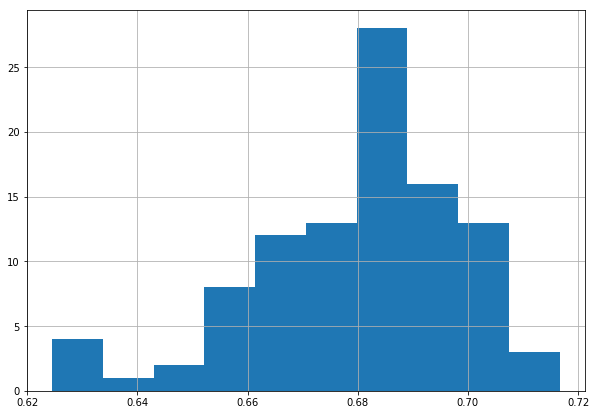